In [1]:
!pip install catboost

     |████████████████████████████████| 65.7MB 54kB/s 


In [2]:
!wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/" "https://datahack-prod.s3.amazonaws.com/train_file/train_Df64byy.csv" -c -O 'train.csv'
!wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/" "https://datahack-prod.s3.amazonaws.com/test_file/test_YCcRUnU.csv" -c -O 'test.csv'

--2021-02-28 15:53:05--  https://datahack-prod.s3.amazonaws.com/train_file/train_Df64byy.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.16
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3049673 (2.9M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.91M  1.89MB/s    in 1.5s    

2021-02-28 15:53:07 (1.89 MB/s) - ‘train.csv’ saved [3049673/3049673]

--2021-02-28 15:53:07--  https://datahack-prod.s3.amazonaws.com/test_file/test_YCcRUnU.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.16
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1268506 (1.2M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.21M 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings 
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from scipy.stats import mode
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [110]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.fillna('unknown',inplace=True)
test_data.fillna('unknown',inplace=True)

cols = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type',
        'Accomodation_Type','Reco_Insurance_Type','Is_Spouse']

train_data['Region_Code_encoded'] , bins = pd.cut(train_data.Region_Code,bins=20,labels=[f'bin_{i}' for i in range(20) ],retbins=True)
test_data['Region_Code_encoded'] = pd.cut(test_data.Region_Code,bins=bins,labels=[f'bin_{i}' for i in range(20) ],retbins=False)

for col in cols + ['City_Code','Region_Code_encoded']:
  encoder = LabelEncoder()
  train_data[col] = encoder.fit_transform(train_data[col].astype(str))
  test_data[col] =  encoder.transform(test_data[col].astype(str))
  try :
    m = encoder.transform(["unknown"])
  except :
    m = None
  
  if m is not None:
    train_data[col] = train_data[col].apply(lambda x: np.NaN if x == m[0] else x)
    test_data[col] = test_data[col].apply(lambda x: np.NaN if x == m[0] else x)


cols = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']

merge = pd.concat([train_data,test_data])

for col in cols:
  X = merge[~merge[col].isna()].drop(['ID',*cols],axis=1)
  Y = merge[~merge[col].isna()][col]
  
  model = LGBMClassifier()
  model.fit(X.drop('Response',axis=1),Y) 
  
  merge['corrected'] = model.predict(merge.drop(['ID','Response',*cols],axis=1))

  merge[col] = merge.apply(lambda x: x['corrected'] if np.isnan(x[col]) else x[col],axis=1)

  merge.drop(['corrected'],axis=1,inplace=True)

## 1
merge['comb_1'] = merge.City_Code.astype(str) + merge.Region_Code.astype(str) 
merge['comb_1'] = merge['comb_1'].map(merge['comb_1'].value_counts(normalize=True))

## 2
m = merge.groupby('Region_Code')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['Region_Code'] + [f'Region_Code_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Region_Code",how="left")

m = merge.groupby('comb_1')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_1'] + [f'comb_1_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_1",how="left")

## 3
merge['comb_2'] = merge.City_Code.astype(str) + merge.Reco_Policy_Cat.astype(str) 
merge['comb_2'] = merge['comb_2'].map(merge['comb_2'].value_counts(normalize=True))

## 4
m = merge.groupby('Reco_Policy_Cat')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Reco_Policy_Cat",how="left")

m = merge.groupby('comb_2')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_2'] + [f'comb_2_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_2",how="left")

## 5
merge['comb_3'] = merge.Region_Code.astype(str) + merge.Reco_Policy_Cat.astype(str) 
merge['comb_3'] = merge['comb_3'].map(merge['comb_3'].value_counts(normalize=True))

## 6
m = merge.groupby('comb_3')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_3'] + [f'comb_3_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_3",how="left")

## 5
merge['comb_4'] = merge.City_Code.astype(str) + merge.Reco_Policy_Cat.astype(str) + merge.Region_Code.astype(str) 
merge['comb_4'] = merge['comb_4'].map(merge['comb_4'].value_counts(normalize=True))

## 6
m = merge.groupby('comb_4')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_4'] + [f'comb_4_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_4",how="left")

## 7
m = merge.groupby('Region_Code')['Upper_Age'].agg(['mean']).reset_index()
m.columns = ['Region_Code'] + [f'Region_Code_Upper_Age_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Region_Code",how="left")

## 8
merge['comb_5'] = merge.Reco_Policy_Cat.astype(str) + merge.Holding_Policy_Type.astype(str)
merge['comb_5'] = merge['comb_5'].map(merge['comb_5'].value_counts(normalize=True))

## 9
m = merge.groupby('comb_5')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_5'] + [f'comb_5_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_5",how="left")

## 10
m = merge.groupby('Reco_Policy_Cat')['Upper_Age'].agg(['mean']).reset_index()
m.columns = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Upper_Age_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Reco_Policy_Cat",how="left")

## 11
merge['comb_6'] = merge.City_Code.astype(str) + merge.Holding_Policy_Type.astype(str)
merge['comb_6'] = merge['comb_6'].map(merge['comb_6'].value_counts(normalize=True))

## 12
m = merge.groupby('comb_6')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_6'] + [f'comb_6_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_6",how="left")

## 13
m = merge.groupby('Health Indicator')['Reco_Policy_Premium'].agg(['mean']).reset_index()
m.columns = ['Health Indicator'] + [f'Health Indicator_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Health Indicator",how="left")

## 14
m = merge.groupby('Holding_Policy_Duration')['Reco_Policy_Premium'].agg(['mean']).reset_index()
m.columns = ['Holding_Policy_Duration'] + [f'Holding_Policy_Duration_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Holding_Policy_Duration",how="left")

## 15
m = merge.groupby('Reco_Policy_Cat')['Region_Code'].agg(['nunique','count']).reset_index()
m.columns = ['Reco_Policy_Cat'] + [f'Reco_Policy_Cat_Region_Code_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="Reco_Policy_Cat",how="left")

## 16
merge['comb_7'] = merge.City_Code.astype(str) + merge.Holding_Policy_Duration.astype(str)
merge['comb_7'] = merge['comb_7'].map(merge['comb_7'].value_counts(normalize=True))

## 17
merge['comb_8'] = merge.City_Code.astype(str) + merge['Health Indicator'].astype(str)
merge['comb_8'] = merge['comb_8'].map(merge['comb_8'].value_counts(normalize=True))

## 18
# merge['comb_9'] = merge.Reco_Policy_Cat.astype(str) + merge['Health Indicator'].astype(str)
# merge['comb_9'] = merge['comb_9'].map(merge['comb_9'].value_counts(normalize=True))

## 19
m = merge.groupby('comb_7')['Reco_Policy_Premium'].agg(['mean','max','min']).reset_index()
m.columns = ['comb_7'] + [f'comb_7_Reco_Policy_Premium_{i}' for i in m.columns[1:]]
merge = merge.merge(m,on="comb_7",how="left")

 ## 20
# m = merge.groupby('comb_2')['comb_4'].agg(['nunique','count']).reset_index()
# m.columns = ['comb_2'] + [f'comb_2_comb_4_{i}' for i in m.columns[1:]]
# merge = merge.merge(m,on="comb_2",how="left")

 ## 21
# m = merge.groupby('comb_1')['comb_4'].agg(['nunique','count']).reset_index()
# m.columns = ['comb_1'] + [f'comb_1_comb_4_{i}' for i in m.columns[1:]]
# merge = merge.merge(m,on="comb_1",how="left")

train_data = merge[~merge.Response.isna()]
test_data = merge[merge.Response.isna()].drop('Response',axis=1)

train_data

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Region_Code_encoded,comb_1,Region_Code_Reco_Policy_Premium_mean,Region_Code_Reco_Policy_Premium_max,Region_Code_Reco_Policy_Premium_min,comb_1_Reco_Policy_Premium_mean,comb_1_Reco_Policy_Premium_max,comb_1_Reco_Policy_Premium_min,comb_2,Reco_Policy_Cat_Reco_Policy_Premium_mean,Reco_Policy_Cat_Reco_Policy_Premium_max,Reco_Policy_Cat_Reco_Policy_Premium_min,comb_2_Reco_Policy_Premium_mean,comb_2_Reco_Policy_Premium_max,comb_2_Reco_Policy_Premium_min,comb_3,comb_3_Reco_Policy_Premium_mean,comb_3_Reco_Policy_Premium_max,comb_3_Reco_Policy_Premium_min,comb_4,comb_4_Reco_Policy_Premium_mean,comb_4_Reco_Policy_Premium_max,comb_4_Reco_Policy_Premium_min,Region_Code_Upper_Age_mean,comb_5,comb_5_Reco_Policy_Premium_mean,comb_5_Reco_Policy_Premium_max,comb_5_Reco_Policy_Premium_min,Reco_Policy_Cat_Upper_Age_mean,comb_6,comb_6_Reco_Policy_Premium_mean,comb_6_Reco_Policy_Premium_max,comb_6_Reco_Policy_Premium_min,Health Indicator_Reco_Policy_Premium_mean,Holding_Policy_Duration_Reco_Policy_Premium_mean,Reco_Policy_Cat_Region_Code_nunique,Reco_Policy_Cat_Region_Code_count,comb_7,comb_8,comb_7_Reco_Policy_Premium_mean,comb_7_Reco_Policy_Premium_max,comb_7_Reco_Policy_Premium_min
0,1,22,3213,1,0,36,36,0,0.0,5.0,2.0,22,11628.0,0.0,2,0.000138,12130.080000,27596.8,4002.0,14164.909296,40550.4,2624.0,0.007292,14589.814674,42316.8,2464.0,14070.144906,35037.0,2712.0,0.000014,14066.644022,42739.2,2400.0,0.000014,14074.029042,42739.2,2400.0,40.700000,0.069105,14003.593988,42256.0,2464.0,44.595306,0.044258,13765.574510,41496.0,2548.0,13587.189675,18459.859390,2862,9459,0.018201,0.043529,17973.844747,41496.0,6696.0
1,2,31,1117,0,1,75,22,0,1.0,5.0,2.0,22,30510.0,0.0,13,0.000289,16076.342857,39398.4,4074.0,14256.315580,39960.0,2600.0,0.001458,14589.814674,42316.8,2464.0,14318.756604,39398.4,3984.0,0.000220,14209.203549,39398.4,2700.0,0.000220,14061.558333,39398.4,2700.0,41.333333,0.069105,14003.593988,42256.0,2464.0,44.595306,0.012423,13430.287929,36448.0,2736.0,15079.031053,18459.859390,2862,9459,0.004347,0.006191,18339.926582,37962.0,7994.0
2,3,31,3732,0,0,32,32,0,0.0,0.0,0.0,19,7450.0,1.0,4,0.000110,11336.000000,19680.0,5344.0,14079.977220,38476.8,2472.0,0.001596,14714.576838,43046.4,2624.0,12584.374138,35872.0,2508.0,0.000028,13973.244532,41648.0,2152.0,0.000028,13947.101367,41648.0,2152.0,35.125000,0.053462,13829.736644,43046.4,2624.0,45.305697,0.008145,13000.609797,39398.4,3678.0,13587.189675,11068.057509,1599,5319,0.009011,0.012437,11444.826870,39398.4,2736.0
3,4,16,4378,0,1,52,48,0,0.0,5.0,2.0,19,17780.0,0.0,6,0.000069,14329.200000,17780.0,10962.0,14280.527336,37590.4,2668.0,0.001169,14714.576838,43046.4,2624.0,14964.381176,43046.4,3624.0,0.000014,14066.644022,42739.2,2400.0,0.000014,14074.029042,42739.2,2400.0,48.400000,0.011240,17766.363525,40550.4,3930.0,45.305697,0.002944,16259.319626,42012.8,3972.0,13587.189675,18459.859390,1599,5319,0.002339,0.004375,18130.344706,42012.8,8386.0
4,5,34,2190,1,0,44,44,0,1.0,8.0,0.0,16,10404.0,0.0,17,0.000193,16664.157143,22932.0,9328.0,14301.799689,38851.2,2512.0,0.003192,14264.687867,39528.0,2380.0,13681.716379,34054.4,2488.0,0.000151,14319.653641,43776.0,2908.0,0.000151,14293.252217,43776.0,2908.0,49.785714,0.056475,13474.317125,37900.8,2380.0,44.441410,0.008475,12011.247078,33792.0,2472.0,15079.031053,13088.703172,1857,5786,0.003316,0.009369,12079.000000,37574.4,3564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,50878,30,845,1,0,22,22,0,2.0,7.0,2.0,18,7704.0,0.0,12,0.000358,11601.246154,24816.0,5504.0,13727.865324,39702.4,2408.0,0.010676,14662.230748,43350.4,2596.0,13107.845619,37900.8,2596.0,0.000248,14158.726901,37264.0,27

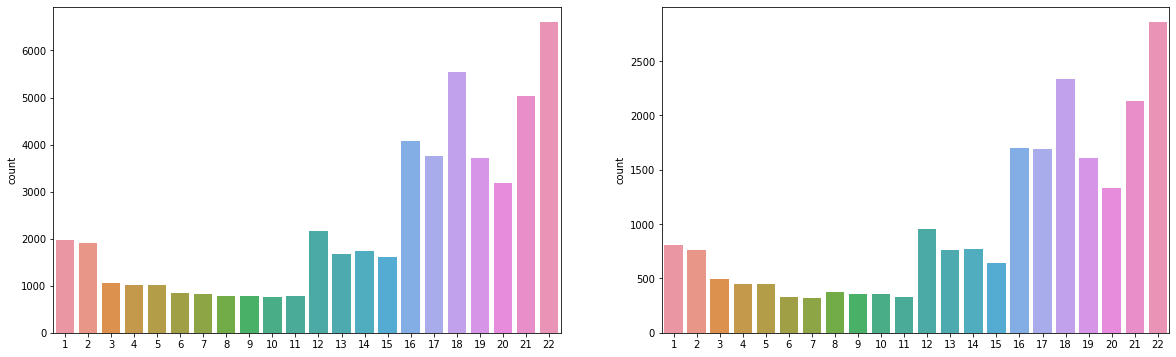

In [111]:
col = train_data.columns[11]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

sns.countplot(sorted(train_data[col]),ax=ax[0])
sns.countplot(sorted(test_data[col]),ax=ax[1])


# train_data.nunique()
# train_data.select_dtypes(object)

In [112]:
# sns.distplot(train_data.Region_Code)
# sns.distplot(test_data.Region_Code)

In [113]:
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Response','ID'],axis=1)
Y = train_data['Response']

folds = StratifiedKFold(n_splits=6,shuffle=True ,random_state=42)

final_preds = pd.DataFrame()
scores = []
best_score = 0

for i , (train_idx, test_idx) in enumerate(folds.split(X,Y)):
  train_set=(X.iloc[train_idx],Y.iloc[train_idx])
  test_set=(X.iloc[test_idx],Y.iloc[test_idx])

  model = LGBMClassifier(metric="auc",
                         learning_rate = 0.08,
                         n_estimators=5000,
                         num_leaves=20,
                         random_state=7,
                        #  subsample=0.95
                        #  reg_alpha=0.001,
                        #  reg_lambda=0.01
                         )
  model.fit(*train_set,
            eval_set=(test_set),
            verbose=500,
            early_stopping_rounds=500)
    
  preds = model.predict_proba(test_set[0])[:,1]
  score = roc_auc_score(test_set[1],preds)
  print("Score:: ",score)
  scores.append(score)

  if best_score < score:
    best_model = model
    best_score = score

  predictions = model.predict_proba(test_data.drop('ID',axis=1))[:,1]
  final_preds[i] = predictions

  # break

print('Mean Score',np.mean(scores))

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.797021
Early stopping, best iteration is:
[127]	valid_0's auc: 0.800977
Score::  0.8009770834778592
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.811626
Early stopping, best iteration is:
[218]	valid_0's auc: 0.814638
Score::  0.8146378799186742
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.810772
Early stopping, best iteration is:
[305]	valid_0's auc: 0.812591
Score::  0.8125908195488974
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.799118
Early stopping, best iteration is:
[109]	valid_0's auc: 0.80319
Score::  0.8031902146874994
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.805231
Early stopping, best iteration is:
[499]	valid_0's auc: 0.805294
Score::  0.8052944685993562
Training until validation scores don't improve for 500 rounds.
[500]	va

In [117]:
pd.DataFrame(list(zip(X.columns,best_model.feature_importances_))).sort_values(1,ascending=False)

,0,1
11,Reco_Policy_Premium,178
31,comb_4,167
10,Reco_Policy_Cat,158
16,Region_Code_Reco_Policy_Premium_min,156
1,Region_Code,151
26,comb_2_Reco_Policy_Premium_min,138
20,comb_2,134
13,comb_1,133
35,Region_Code_Upper_Age_mean,132
36,comb_5,122


In [118]:
submission = pd.DataFrame(np.mean(final_preds,axis=1),columns=['Response'])
submission['ID'] = test_data.ID.values
submission  = submission[['ID','Response']]
submission.to_csv("lgbm_submission.csv",index=None)
submission

,ID,Response
0,50883,0.111148
1,50884,0.115849
2,50885,0.438472
3,50886,0.092415
4,50887,0.052423
...,...,...
21800,72683,0.046264
21801,72684,0.098635
21802,72685,0.003277
21803,72686,0.518047


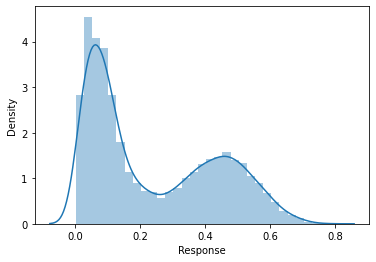

In [119]:
sns.distplot(submission['Response'])

In [121]:
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Response','ID'],axis=1)
Y = train_data['Response']

folds = StratifiedKFold(n_splits=6,shuffle=True ,random_state=42)

final_preds = pd.DataFrame()
scores = []
best_score = 0

for i , (train_idx, test_idx) in enumerate(folds.split(X,Y)):
  train_set=(X.iloc[train_idx],Y.iloc[train_idx])
  test_set=(X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(eval_metric="AUC",
                            learning_rate = 0.08,
                            n_estimators=5000,
                            # num_leaves=20,
                            random_state=7,
                            #  subsample=0.95
                        #  reg_alpha=0.001,
                        #  reg_lambda=0.01
                         )
  model.fit(*train_set,
            eval_set=(test_set),
            verbose=500,
            early_stopping_rounds=500)
    
  preds = model.predict_proba(test_set[0])[:,1]
  score = roc_auc_score(test_set[1],preds)
  print("Score:: ",score)
  scores.append(score)

  if best_score < score:
    best_model = model
    best_score = score

  predictions = model.predict_proba(test_data.drop('ID',axis=1))[:,1]
  final_preds[i] = predictions

  # break

print('Mean Score',np.mean(scores))

0:	test: 0.7578312	best: 0.7578312 (0)	total: 36.3ms	remaining: 3m 1s
500:	test: 0.7993415	best: 0.7999795 (275)	total: 16.6s	remaining: 2m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7999794932
bestIteration = 275

Shrink model to first 276 iterations.
Score::  0.7999794932156085
0:	test: 0.7692890	best: 0.7692890 (0)	total: 34.9ms	remaining: 2m 54s
500:	test: 0.8140352	best: 0.8142855 (372)	total: 16.7s	remaining: 2m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8142855291
bestIteration = 372

Shrink model to first 373 iterations.
Score::  0.814285529147459
0:	test: 0.7718420	best: 0.7718420 (0)	total: 33.1ms	remaining: 2m 45s
500:	test: 0.8098877	best: 0.8102699 (246)	total: 16.5s	remaining: 2m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8102699348
bestIteration = 246

Shrink model to first 247 iterations.
Score::  0.8102699348433137
0:	test: 0.7615147	best: 0.7615147 (0)	total: 32.8ms	remaining: 2m

In [122]:
submission = pd.DataFrame(np.mean(final_preds,axis=1),columns=['Response'])
submission['ID'] = test_data.ID.values
submission  = submission[['ID','Response']]
submission.to_csv("cat_submission.csv",index=None)
submission

,ID,Response
0,50883,0.096267
1,50884,0.101306
2,50885,0.443676
3,50886,0.076438
4,50887,0.059102
...,...,...
21800,72683,0.045573
21801,72684,0.118732
21802,72685,0.013547
21803,72686,0.514612


In [126]:
lgbm = pd.read_csv('lgbm_submission.csv')
cat = pd.read_csv('cat_submission.csv')

f = (lgbm['Response']+cat['Response'])/2

submission = pd.DataFrame(f,columns=['Response'])
submission['ID'] = test_data.ID.values
submission  = submission[['ID','Response']]
submission.to_csv("submission.csv",index=None)
submission

,ID,Response
0,50883,0.103707
1,50884,0.108578
2,50885,0.441074
3,50886,0.084426
4,50887,0.055762
...,...,...
21800,72683,0.045918
21801,72684,0.108684
21802,72685,0.008412
21803,72686,0.516329


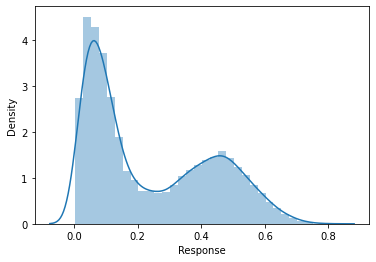

In [127]:
sns.distplot(submission['Response'])